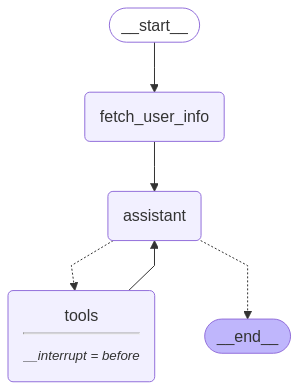

In [1]:
from IPython.display import Image, display
from travel_assistant_bot.workflow import graph

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import uuid

from langchain_core.messages import ToolMessage

from tools.utils import _print_event
from database import update_dates, db_file


# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    # This sentence will invoke 2 (parallel) tool calls
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
update_dates(db_file)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)},
        config,
        stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

    snapshot = graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=tool_call["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                        for tool_call in event["messages"][-1].tool_calls
                    ]
                },
                config,
            )
        snapshot = graph.get_state(config)

Database already downloaded.
Updating dates in the database...
['aircrafts_data', 'airports_data', 'boarding_passes', 'bookings', 'flights', 'seats', 'ticket_flights', 'tickets', 'car_rentals', 'hotels', 'trip_recommendations']
Database updated successfully.
================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

Your flight (LX0112) is scheduled to depart from Paris Charles de Gaulle Airport (CDG) at 00:42 (local time) on May 9, 2025, and arrive at EuroAirport Basel-Mulhouse-Freiburg (BSL) at 02:12 (local time) on the same day. Your seat number is 18E in Economy class.

If you need any more details or assistance, please let me know!
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message =====

E:\Docs\aia\travel-assistant-bot\src\database\travel2.sqlite
